01_import dataset
===

In [1]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


02_rename variable in each data set
===

In [2]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




03_變數型態統一及缺失值處理
===

In [3]:
def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

In [4]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = -1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(-999)
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [5]:
#cars one heart encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip', 'card_on_dark_web']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_chip = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_chip], axis=1)

#gender 原始種類：Female_51%, Male_49%, Online_12%
dummies_chip = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_chip], axis=1)


cards_df.drop(columns=["card_type", "card_brand", "has_chip", "card_on_dark_web","has_chip_NO"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)

In [ ]:
##不用執行～～(本來試圖建立對照表將Missing的zip補上)

##檢查89006筆Missing的zip
c_missing_zip = transactions_df[transactions_df["zip"].isna()]
c_mexico_zip = transactions_df[transactions_df["merchant_state"]=="Mexico"]
#c_mcc_mv_zip = c_missing_zip[
#    (c_missing_zip["mcc_code"] > 5400) & (c_missing_zip["mcc_code"] < 5700)
#]



# 先建立 mapping table：一組 state+city 可能對應多個 zip
mapping_df = (
    transactions_df
    .dropna(subset=["zip"])                                   # 只要 zip 有值的 row
    .drop_duplicates(subset=["merchant_state", "merchant_city", "zip"]) 
    [["merchant_state", "merchant_city", "zip"]]              # 只留下需要的欄位
)

print(mapping_df.head())


# 假設 df 已經存在
# 建立新的欄位 F，B 與 C 合併
c_missing_zip["fullname"] = c_missing_zip["merchant_city"].astype(str) + c_missing_zip["merchant_state"].astype(str)
# 建立新的 DataFrame，只取 A, D, F
df_small = c_missing_zip[["transaction_id", "fullname","zip"]]

mapping_df["mfullname"] = mapping_df["merchant_city"].astype(str) + mapping_df["merchant_state"].astype(str)

# 先建立一個 lookup 字典
lookup_dict = dict(zip(mapping_df["mfullname"], mapping_df["zip"]))

# 用 map 當作 vlookup
df_small["zip"] = df_small["zip"].fillna(df_small["fullname"].map(lookup_dict))




05_data資料整合
===

In [5]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

In [6]:
del transactions_df, users_df, cards_df, train_fraud_labels_df

In [8]:
merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])
#merged.to_csv("merged.csv", index=False)

06_EDA_Exploratory-Data-Analysis
==

06-1_資料型態
==

merged資料：8914963x37

In [7]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 40 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   transaction_id               int64         
 1   date                         datetime64[ns]
 2   client_id_x                  int64         
 3   card_id                      int64         
 4   amount                       int64         
 5   use_chip                     category      
 6   merchant_id                  int64         
 7   merchant_city                object        
 8   merchant_state               object        
 9   zip                          int64         
 10  mcc_code                     int64         
 11  errors                       category      
 12  merchant_state_missing_flag  int64         
 13  zip_missing_flag             int64         
 14  errors_missing_flag          int64         
 15  is_fraud                     category      
 16

06-2_資料統計指標
==

In [8]:
merged.describe()

,transaction_id,date,client_id_x,card_id,amount,merchant_id,zip,mcc_code,merchant_state_missing_flag,zip_missing_flag,...,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_number,cvv,num_cards_issued,credit_limit
count,1.330592e+07,13305915,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,...,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07
mean,1.558402e+07,2015-01-06 06:50:27.604354816,1.026812e+03,3.475268e+03,4.255423e+01,4.772376e+04,4.494568e+04,5.565440e+03,1.175192e-01,1.242084e-01,...,-9.157160e+01,2.397965e+04,4.668369e+04,5.802207e+04,7.139113e+02,3.841550e+00,4.817333e+15,4.953317e+02,1.522133e+00,1.554983e+04
min,7.475327e+06,2010-01-01 00:01:00,0.000000e+00,0.000000e+00,-5.000000e+02,1.000000e+00,-9.990000e+02,1.711000e+03,0.000000e+00,0.000000e+00,...,-1.581800e+02,0.000000e+00,1.000000e+00,0.000000e+00,4.880000e+02,1.000000e+00,3.001055e+14,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.150604e+07,2012-08-08 21:43:00,5.190000e+02,2.413000e+03,8.000000e+00,2.588700e+04,1.508300e+04,5.300000e+03,0.000000e+00,0.000000e+00,...,-9.737000e+01,1.711300e+04,3.281700e+04,1.643700e+04,6.840000e+02,3.000000e+00,4.489873e+15,2.470000e+02,1.000000e+00,8.100000e+03
50%,1.557087e+07,2015-01-22 12:17:00,1.070000e+03,3.584000e+03,2.800000e+01,4.592600e+04,4.110200e+04,5.499000e+03,0.000000e+00,0.000000e+00,...,-8.647000e+01,2.115600e+04,4.106900e+04,5.167900e+04,7.160000e+02,4.000000e+00,5.112842e+15,4.990000e+02,2.000000e+00,1.345500e+04
75%,1.965361e+07,2017-06-13 17:45:00,1.531000e+03,4.901000e+03,6.300000e+01,6.757000e+04,7.550100e+04,5.812000e+03,0.000000e+00,0.000000e+00,...,-8.012000e+01,2.730800e+04,5.401300e+04,8.516000e+04,7.560000e+02,5.000000e+00,5.568043e+15,7.400000e+02,2.000000e+00,2.083900e+04
max,2.376187e+07,2019-10-31 23:59:00,1.998000e+03,6.144000e+03,6.820000e+03,1.003420e+05,9.992800e+04,9.402000e+03,1.000000e+00,1.000000e+00,...,-6.867000e+01,1.631450e+05,2.801990e+05,4.618540e+05,8.500000e+02,9.000000e+00,6.994218e+15,9.990000e+02,3.000000e+00,1.413910e+05
std,4.704499e+06,NaN,5.816386e+02,1.674356e+03,8.164212e+01,2.581534e+04,3.231752e+04,8.757002e+02,3.220379e-01,3.298191e-01,...,1.626134e+01,1.196712e+04,2.444509e+04,5.210096e+04,6.580271e+01,1.567837e+00,1.311537e+15,2.885813e+02,5.152160e-01,1.218106e+04


In [ ]:
merged.describe(include='all')

06-3_類別型資料frequency barchart
==

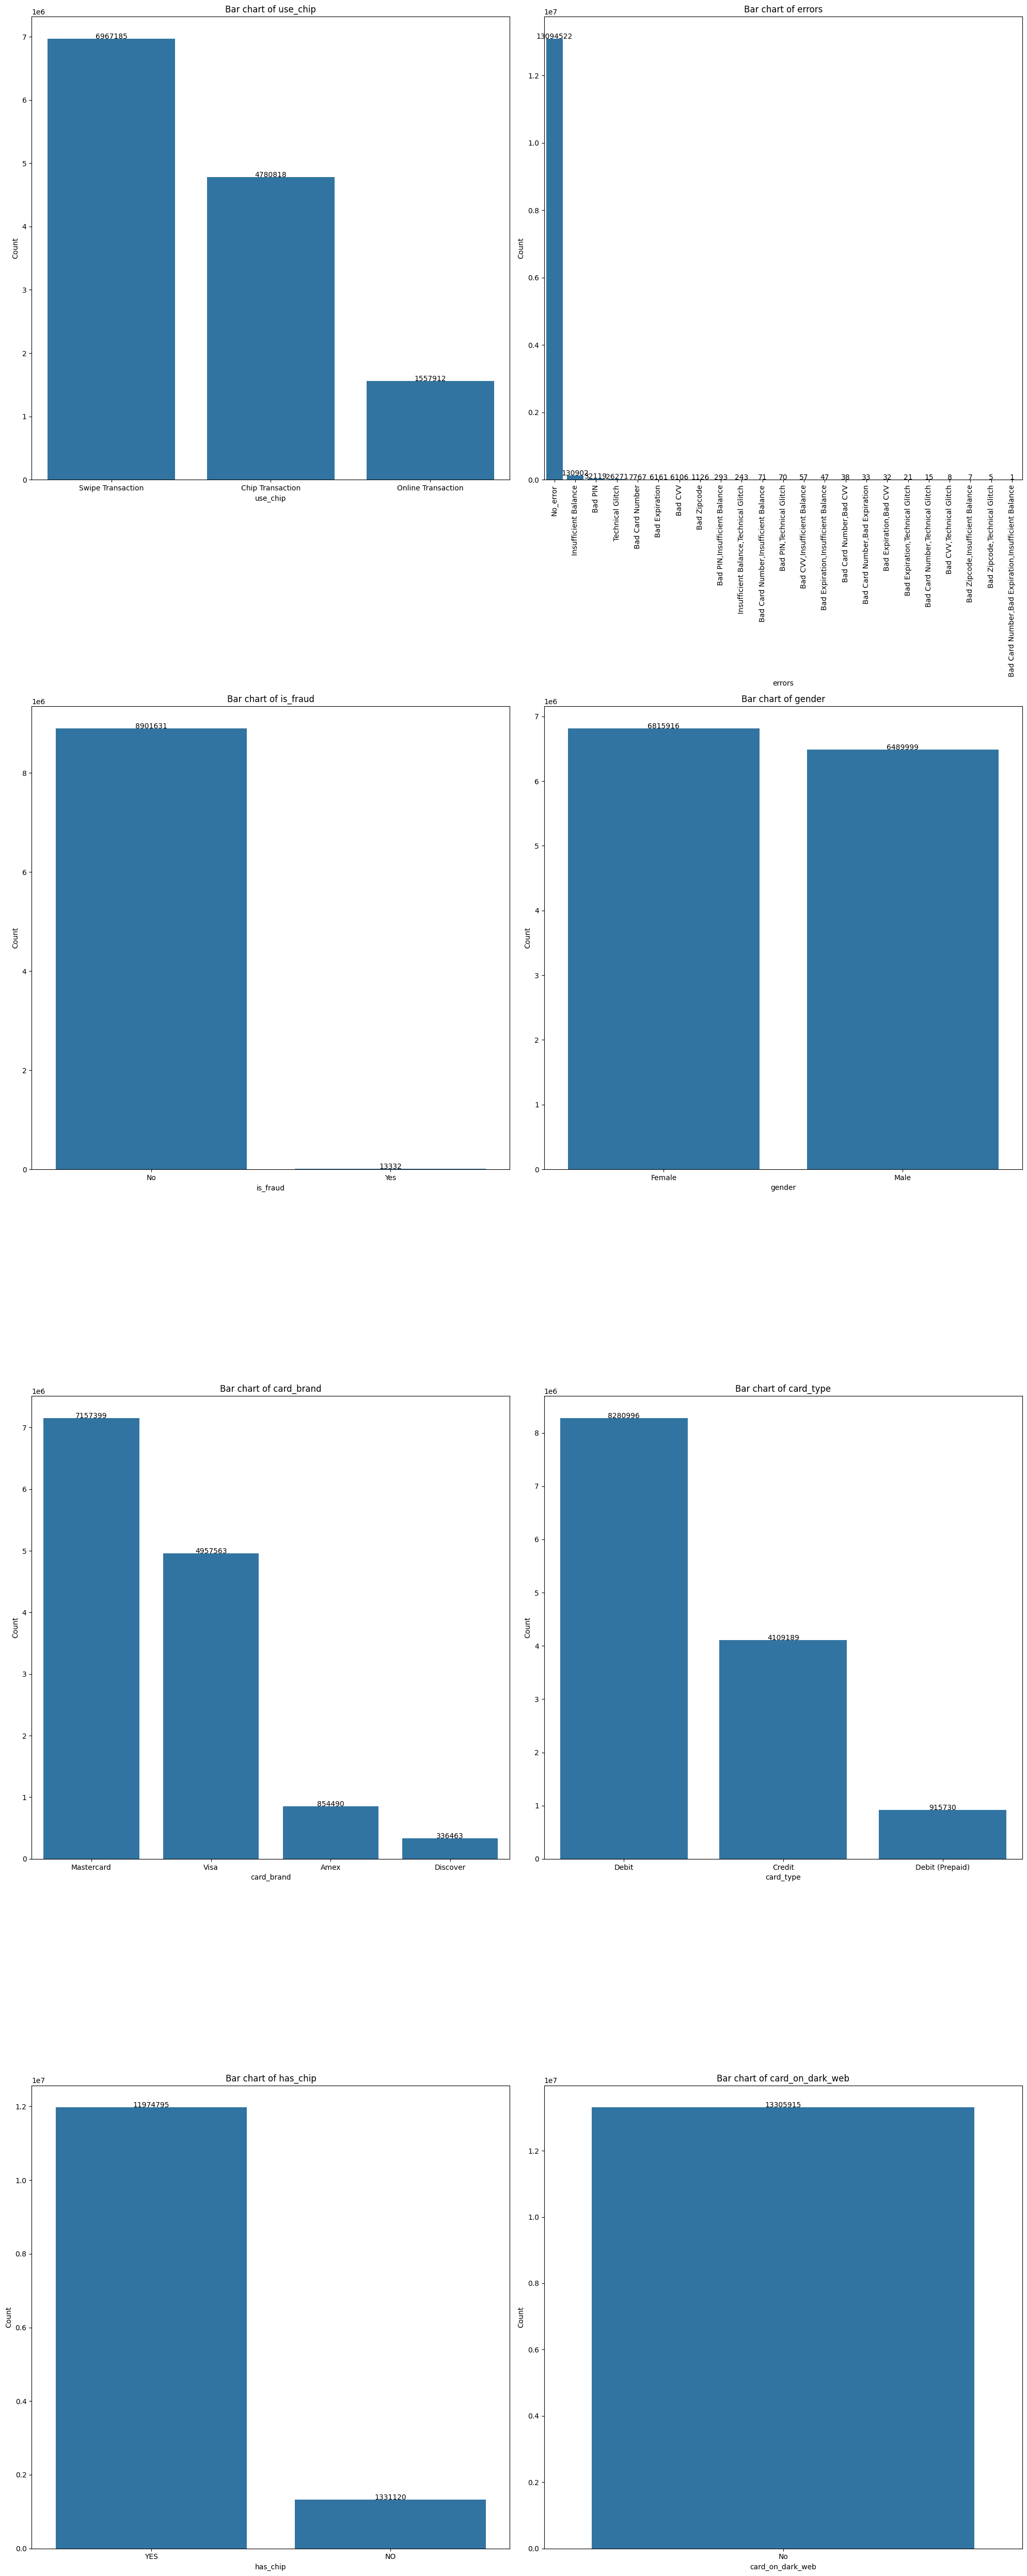

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = merged.select_dtypes(include=["category"]).columns

n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=merged, x=col, order=merged[col].value_counts().index, ax=ax)
    ax.set_title(f"Bar chart of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    if col == "errors":
        ax.tick_params(axis='x', rotation=90)  # X軸標籤旋轉
    else:
        ax.tick_params(axis='x', rotation=0)  # X軸標籤旋轉
    
    # 在長條圖上加數字
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width()/2,
                y=height + 0.05,
                s=int(height),
                ha='center')

# 移除多餘空白子圖
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


06-4_數值型資料histogram
==

In [ ]:
# 設定 subplot 格式
n_cols = 4   # 每列放4張圖
n_rows = 6   # 每行放6列 (共 4x6=24)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))  # 調整大小
axes = axes.flatten()  # 攤平成一維方便迭代
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(num_cols):
    sns.histplot(data=merged, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# 把多餘的 subplot 關掉（避免空白框）
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

06-5_類別型資料box plot
==

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 抓出數值型欄位
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

# 建立 3x8 subplot
fig, axes = plt.subplots(8, 3, figsize=(30, 50))  # 依照需求調整 figsize
axes = axes.flatten()  # 攤平成一維 array，方便迴圈

# 逐一畫圖
for i, col in enumerate(num_cols):
    sns.boxplot(y=merged[col], ax=axes[i])  # 每個 subplot 畫一個 boxplot
    axes[i].set_title(col, fontsize=10)

# 如果欄位數小於 3x8，隱藏多餘的子圖
for j in range(len(num_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


06-7_數值型資料pair wise scatterplot(畫不出來？)
==

In [ ]:
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(merged[num_cols])

06-8_針對詐騙標籤轉成dummy variable
==

In [10]:
cols_to_encode = ['is_fraud']
merged[cols_to_encode] = merged[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    merged[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
merged = pd.concat([merged, dummies_cards], axis=1)
merged.drop(columns=["is_fraud_No","is_fraud"], inplace=True)


In [ ]:
merged["is_fraud_Yes"]=merged["is_fraud_Yes"].astype("int64")
target = 'is_fraud_Yes'  # 假設這是目標
num_cols = merged.select_dtypes(include=['int64','float64']).columns.drop(target)

for col in num_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(merged[col], merged[target], alpha=0.3)  # alpha降低透明度，避免太擠
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"{target} vs {col}")
    plt.show()

06-9_其他觀察 詐騙與否跟時間的關係
==

/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35408 (\N{CJK UNIFIED IDEOGRAPH-8A50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39449 (\N{CJK UNIFIED IDEOGRAPH-9A1

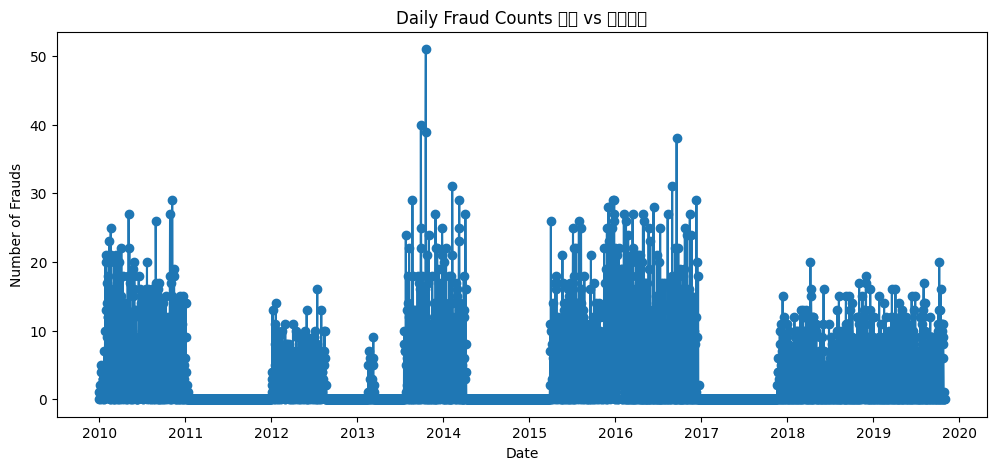

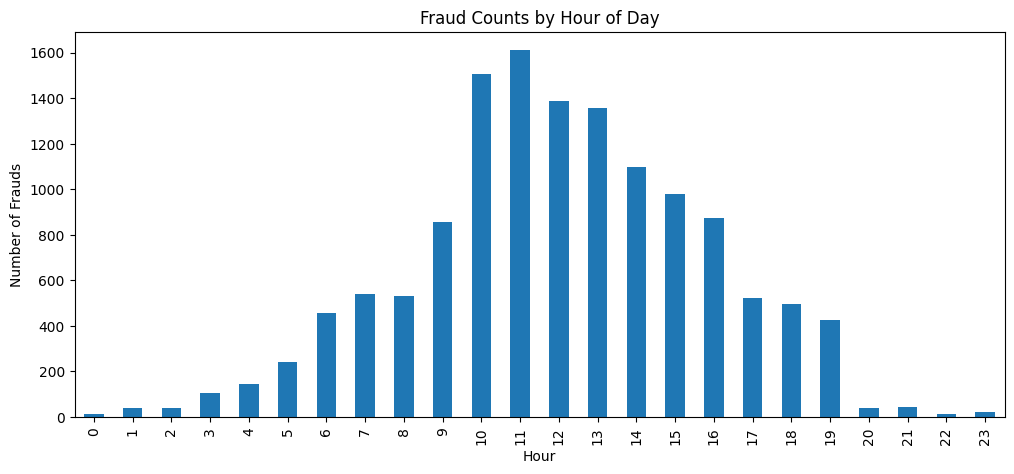

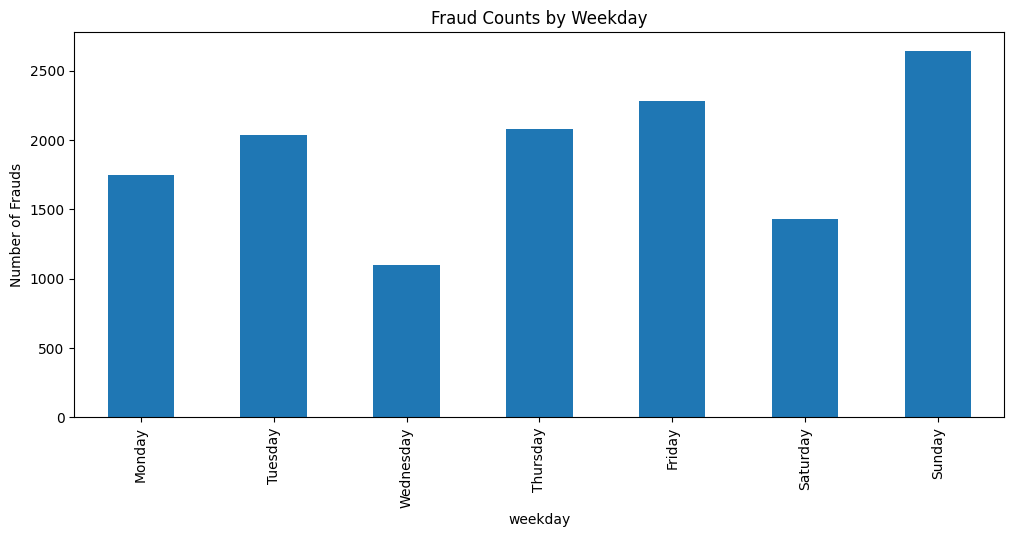

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 確保 date 是 datetime 格式
merged["date"] = pd.to_datetime(merged["date"])

# 按天統計詐騙事件數
fraud_per_day = merged.groupby(merged["date"].dt.date)["is_fraud_Yes"].sum()

# 畫折線圖
plt.figure(figsize=(12,5))
fraud_per_day.plot(kind="line", marker="o")
plt.title("Daily Fraud Counts 日期 vs 詐騙次數")
plt.xlabel("Date")
plt.ylabel("Number of Frauds")
plt.show()


# 按小時
merged["hour"] = merged["date"].dt.hour
hourly_fraud = merged.groupby("hour")["is_fraud_Yes"].sum()

plt.figure(figsize=(12,5))
hourly_fraud.plot(kind="bar")
plt.title("Fraud Counts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Frauds")
plt.show()

# 按星期幾
merged["weekday"] = merged["date"].dt.day_name()
weekday_fraud = merged.groupby("weekday")["is_fraud_Yes"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(12,5))
weekday_fraud.plot(kind="bar")
plt.title("Fraud Counts by Weekday")
plt.ylabel("Number of Frauds")
plt.show()



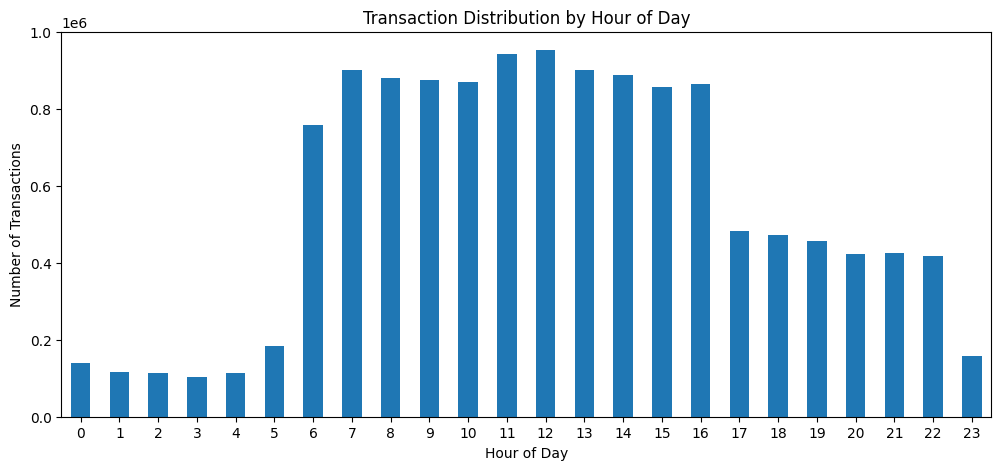

In [13]:
## 想確認原始交易分布與詐騙無關
# 取出小時
merged["hour"] = merged["date"].dt.hour

# 按小時計算交易數
transactions_per_hour = merged["hour"].value_counts().sort_index()

# 畫長條圖
plt.figure(figsize=(12,5))
transactions_per_hour.plot(kind="bar")
plt.title("Transaction Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.show()

06-10_correlation and heatmap
==

In [14]:
numeric_df = merged.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()
print(corr)

                             transaction_id  client_id_x   card_id    amount  \
transaction_id                     1.000000    -0.000891  0.012038 -0.003179   
client_id_x                       -0.000891     1.000000 -0.006068 -0.004267   
card_id                            0.012038    -0.006068  1.000000 -0.004968   
amount                            -0.003179    -0.004267 -0.004968  1.000000   
merchant_id                       -0.001686     0.002080 -0.007036 -0.014598   
zip                               -0.009051    -0.025526  0.008017 -0.042433   
mcc_code                          -0.001433    -0.014021 -0.007869 -0.033984   
merchant_state_missing_flag        0.015185     0.029267  0.011259  0.061717   
zip_missing_flag                   0.016162     0.029406  0.011225  0.058899   
errors_missing_flag               -0.000513     0.003348  0.003010 -0.026494   
current_age                       -0.023360     0.054284  0.008544 -0.004447   
retirement_age                     0.003

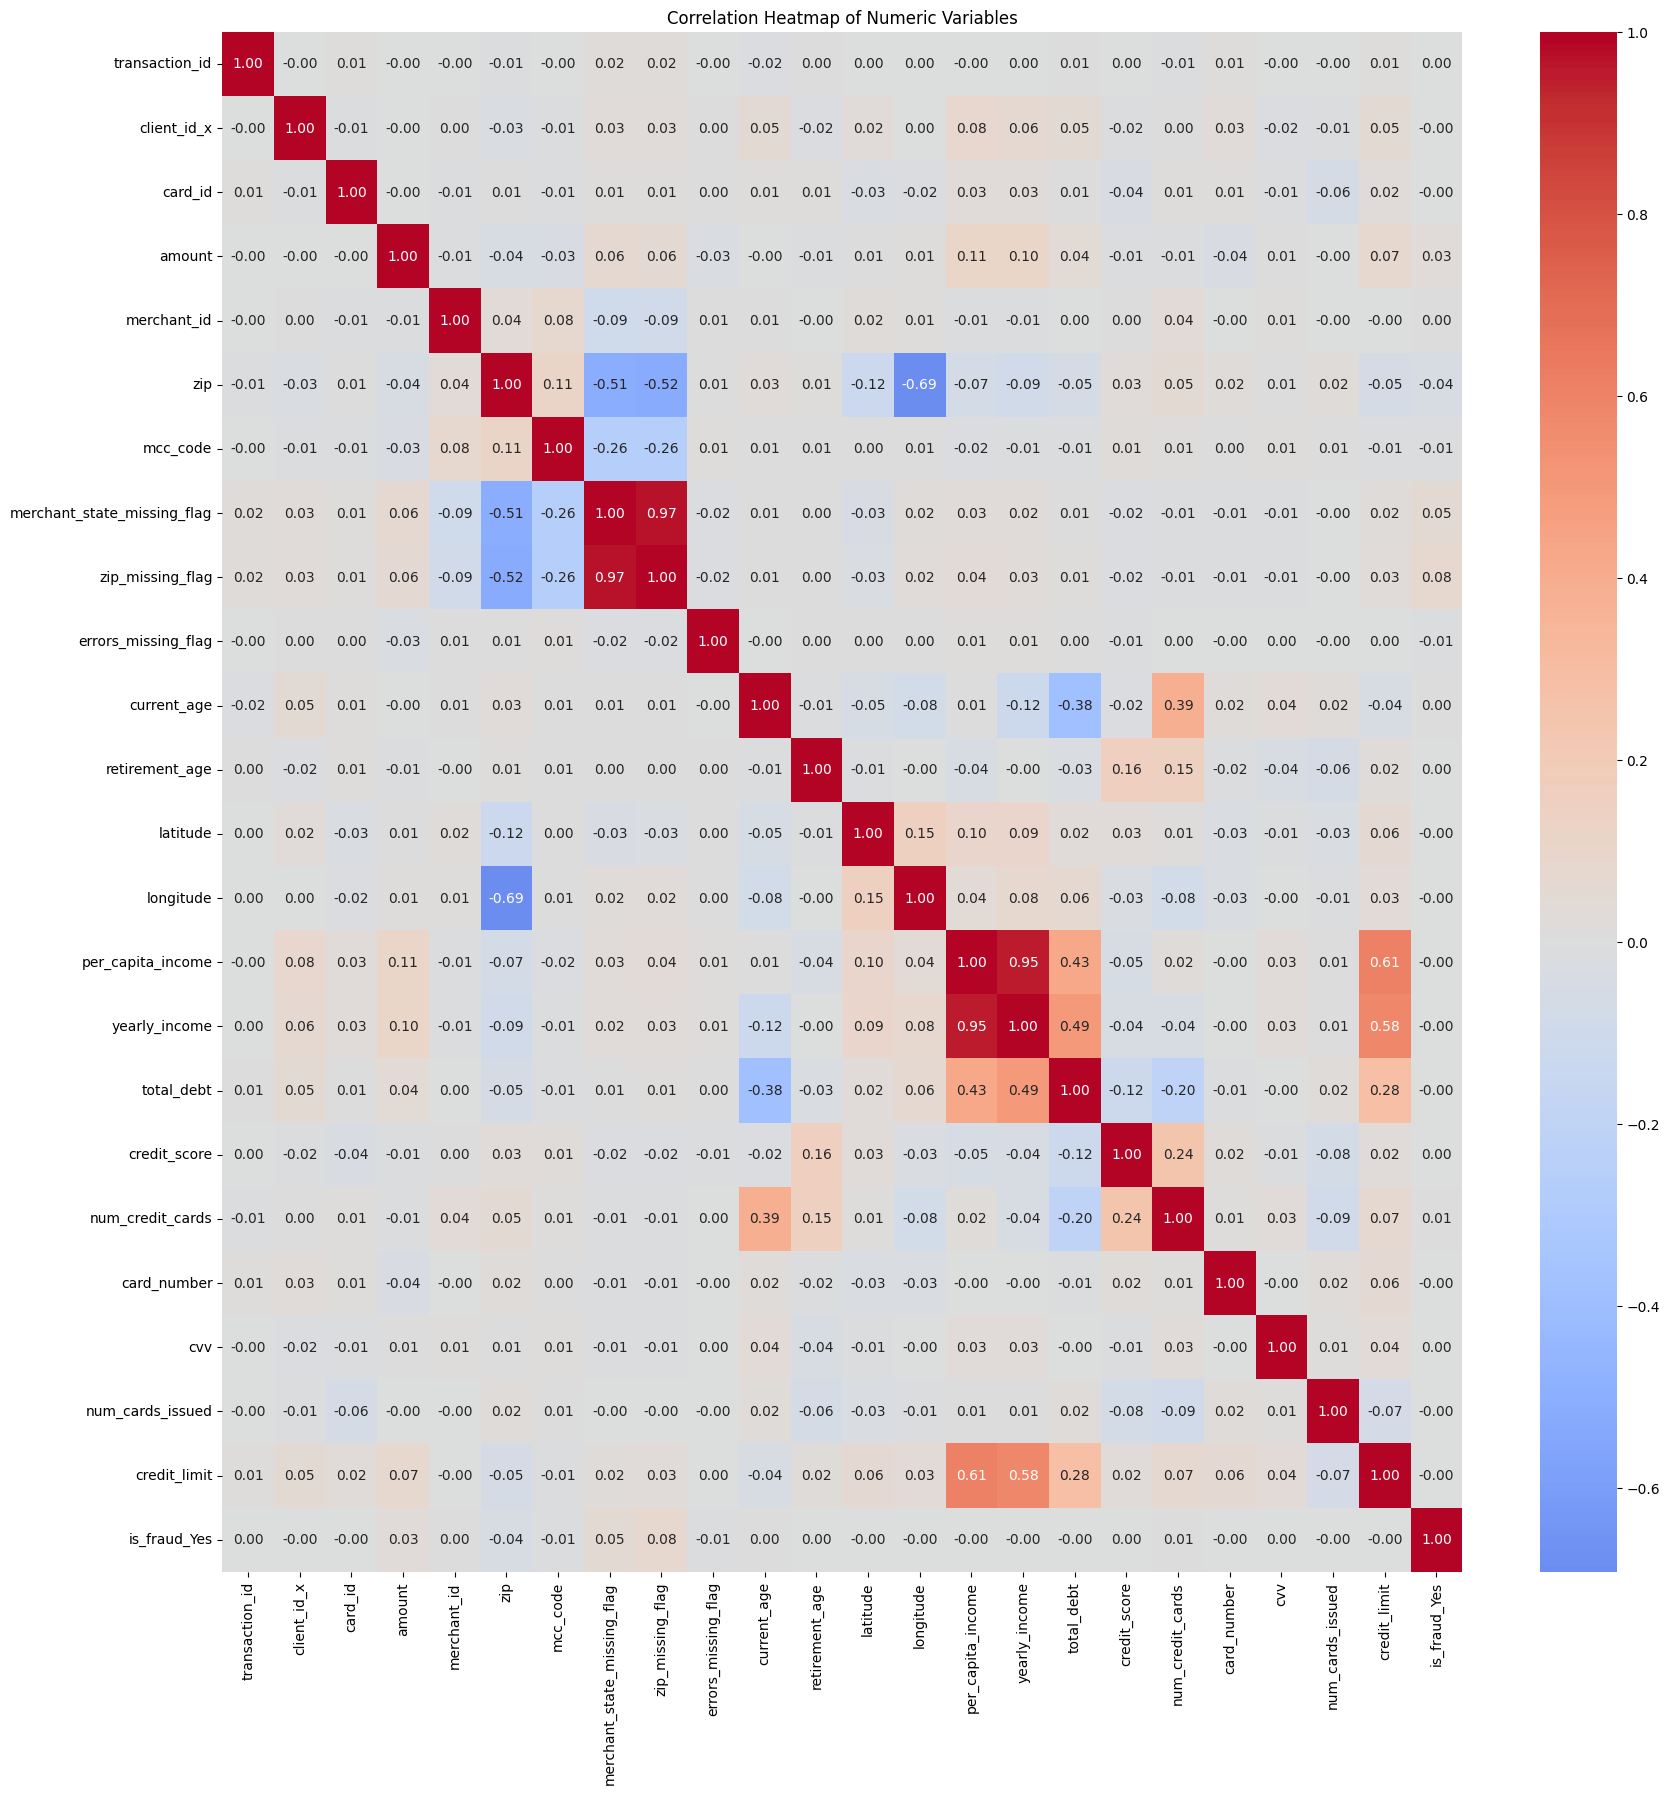

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [16]:
# --- 原始資料 correlation ---
corr_raw = numeric_df.corr()

# --- 標準化後 correlation ---
scaler = StandardScaler()
num_scaled = scaler.fit_transform(numeric_df)   # 轉換成 Numpy array
num_df_scaled = pd.DataFrame(num_scaled, columns=numeric_df.columns)
corr_scaled = num_df_scaled.corr()

# --- 繪圖 (上下對照) ---
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap (Raw Data)")

sns.heatmap(corr_scaled, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap (Standardized Data)")

plt.tight_layout()
plt.show()

NameError: name 'StandardScaler' is not defined

07_categoracal 轉 dummy分析
==

In [ ]:
info_df = pd.DataFrame({
    "column": merged.columns,
    "dtype": merged.dtypes.astype(str)
})
info_df.to_csv("info.csv", index=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
pip install sklearn
import sklearn

In [ ]:
import sklearn